In [48]:
import skvideo.io
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
import xgboost as xgb
import os
import time
import h5py
import pickle
from tqdm import tqdm
import cv2
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
color = sns.color_palette()

%matplotlib inline

In [37]:
DATA_PATH = '/kaggle/dev/speed-challenge-2017-data/data'
TRAIN_LABELS = os.path.join(DATA_PATH, 'train.txt')
PREPROCESSED_DATA_PATH = '/kaggle/dev/speed-challenge-2017-data/pre_processed_data'
PREPROCESSED_IMGS_TRAIN = os.path.join(PREPROCESSED_DATA_PATH, 'train_imgs')
PREPROCESSED_IMGS_TEST = os.path.join(PREPROCESSED_DATA_PATH, 'test_imgs')
TRAIN_META = os.path.join(PREPROCESSED_DATA_PATH, 'train_meta.csv')
TEST_META = os.path.join(PREPROCESSED_DATA_PATH, 'test_meta.csv')
PREDICT_PATH = '/kaggle/dev/speed-challenge-2017-data/predict'
METRICS_PATH = '/kaggle/dev/ashish/car-speed-challenge-2017/metrics'
MODELS_PATH = '/kaggle/dev/ashish/car-speed-challenge-2017/models'

In [3]:
train_y = pd.read_csv(TRAIN_LABELS, header=None, squeeze=True)
train_y.head()

0    28.105569
1    28.105569
2    28.106527
3    28.130404
4    28.109243
Name: 0, dtype: float64

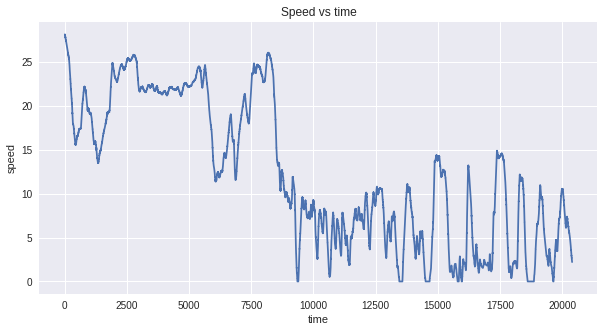

In [4]:
plt.figure(figsize=(10,5))
plt.title('Speed vs time')
plt.ylabel('speed')
plt.xlabel('time')
plt.plot(train_y.index.values, train_y.values)

In [5]:
train_df = pd.read_csv(TRAIN_META)
test_df = pd.read_csv(TEST_META)

In [6]:
train_df.head()

,img_path,img_index,speed
0,/kaggle/dev/speed-challenge-2017-data/pre_proc...,0,28.105569
1,/kaggle/dev/speed-challenge-2017-data/pre_proc...,1,28.105569
2,/kaggle/dev/speed-challenge-2017-data/pre_proc...,2,28.106527
3,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3,28.130404
4,/kaggle/dev/speed-challenge-2017-data/pre_proc...,4,28.109243


In [7]:
test_df.head()

,img_path,img_index,speed
0,/kaggle/dev/speed-challenge-2017-data/pre_proc...,0,NaN
1,/kaggle/dev/speed-challenge-2017-data/pre_proc...,1,NaN
2,/kaggle/dev/speed-challenge-2017-data/pre_proc...,2,NaN
3,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3,NaN
4,/kaggle/dev/speed-challenge-2017-data/pre_proc...,4,NaN


In [8]:
def batch_shuffle(df):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    for i in range(len(df) - 1):
        idx1 = np.random.randint(len(df) - 1)
        idx2 = idx1 + 1
        
        row1 = df.iloc[[idx1]].reset_index()
        row2 = df.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [9]:
train_data, valid_data = batch_shuffle(train_df)

In [10]:
train_data.head()

,index,img_path,img_index,speed
0,5539,/kaggle/dev/speed-challenge-2017-data/pre_proc...,5539,22.142716
0,5540,/kaggle/dev/speed-challenge-2017-data/pre_proc...,5540,22.161229
0,3358,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3358,22.323885
0,3359,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3359,22.338920
0,6729,/kaggle/dev/speed-challenge-2017-data/pre_proc...,6729,16.823230


In [11]:
valid_data.head()

,index,img_path,img_index,speed
0,2802,/kaggle/dev/speed-challenge-2017-data/pre_proc...,2802,25.732077
0,2803,/kaggle/dev/speed-challenge-2017-data/pre_proc...,2803,25.740464
0,10020,/kaggle/dev/speed-challenge-2017-data/pre_proc...,10020,8.509653
0,10021,/kaggle/dev/speed-challenge-2017-data/pre_proc...,10021,8.505750
0,3571,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3571,21.957317


In [12]:
print('valid_data: ', len(valid_data))
print('train_data: ', len(train_data))

valid_data:  9188
train_data:  31610


In [13]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [14]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current,
                                        gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)                                   

    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb_flow

In [15]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    image_cropped = image[25:375, :] # -> (350, 640, 3)
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    return image

In [16]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

CV2 default img (BGR) (480, 640, 3)


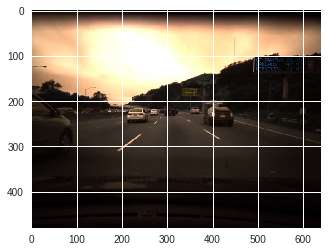

RGB img (480, 640, 3)


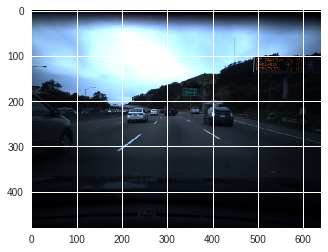

Change brightness img (480, 640, 3)


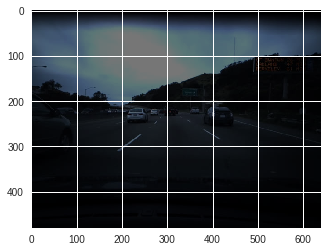

Resized img (66, 220, 3)


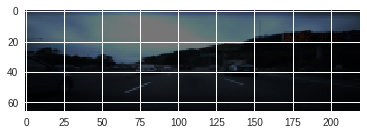

In [17]:
# Example image preprocessing
temp_bright_factor = 0.2 + np.random.uniform()
temp_img = cv2.imread('/kaggle/dev/speed-challenge-2017-data/pre_processed_data/train_imgs/5183.jpg')
print('CV2 default img (BGR)', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
print('RGB img', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = change_brightness(temp_img, temp_bright_factor)
print('Change brightness img', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = preprocess_image(temp_img)
print('Resized img', temp_img.shape)
plt.imshow(temp_img)
plt.show()

In [34]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['img_index'].values[0]
            time_prev = row_prev['img_index'].values[0]
            time_next = row_next['img_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['img_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['img_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [27]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['img_index'].values[0]
            time_prev = row_prev['img_index'].values[0]
            time_next = row_next['img_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(row1['img_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['img_path'].values[0], row2['speed'].values[0])
            
            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed

In [30]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [31]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
print('val_size: ', val_size)

val_size:  9188


In [46]:
ts = str(int(time.time()))
filepath = 'model-{}-weights.h5'.format(ts)
model_name = 'nvidia'
num_epochs = 100
steps_per_epoch = 400
batch_size = 16
run_name = 'model={}-batch_size={}-num_epoch={}-steps_per_epoch={}-ts={}'.format(model_name,
                                                                          batch_size,
                                                                          num_epochs,
                                                                          steps_per_epoch,
                                                                          ts)
tensorboard_loc = os.path.join(METRICS_PATH, run_name)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)
modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
tensorboard = TensorBoard(log_dir=tensorboard_loc, histogram_freq=0,
                            write_graph=True, write_images=True)

callbacks_list = [modelCheckpoint, earlyStopping, tensorboard]

model = nvidia_model()
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, batch_size)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 400, 
        epochs = 25,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)
print(run_name)
model.save(os.path.join(MODELS_PATH, 'model-{}.h5'.format(ts)))
pickle.dump(history.history, open(os.path.join(MODELS_PATH, 'model-{}.history'.format(ts)), "wb"))

Epoch 1/25
400/400 [==============================] - 295s - loss: 56.4376 - val_loss: 27.2162
Epoch 2/25
400/400 [==============================] - 291s - loss: 30.3179 - val_loss: 21.0171
Epoch 3/25
400/400 [==============================] - 291s - loss: 21.3989 - val_loss: 15.7841
Epoch 4/25
400/400 [==============================] - 290s - loss: 17.3379 - val_loss: 12.5471
Epoch 5/25
400/400 [==============================] - 290s - loss: 14.6360 - val_loss: 11.5507
Epoch 6/25
400/400 [==============================] - 291s - loss: 12.9137 - val_loss: 9.2994
Epoch 7/25
400/400 [==============================] - 290s - loss: 11.4504 - val_loss: 8.1765
Epoch 8/25
400/400 [==============================] - 291s - loss: 9.8275 - val_loss: 8.6350
Epoch 9/25
400/400 [==============================] - 291s - loss: 9.2271 - val_loss: 7.7449
Epoch 10/25
400/400 [==============================] - 289s - loss: 8.6661 - val_loss: 6.0515
Epoch 11/25
400/400 [==============================] - 29

NameError: name 'pickle' is not defined

In [52]:
model = load_model(os.path.join(MODELS_PATH, 'model-1503373751.h5'))
history = pickle.load(open(os.path.join(MODELS_PATH, 'model-1503373751.history'), 'rb'))

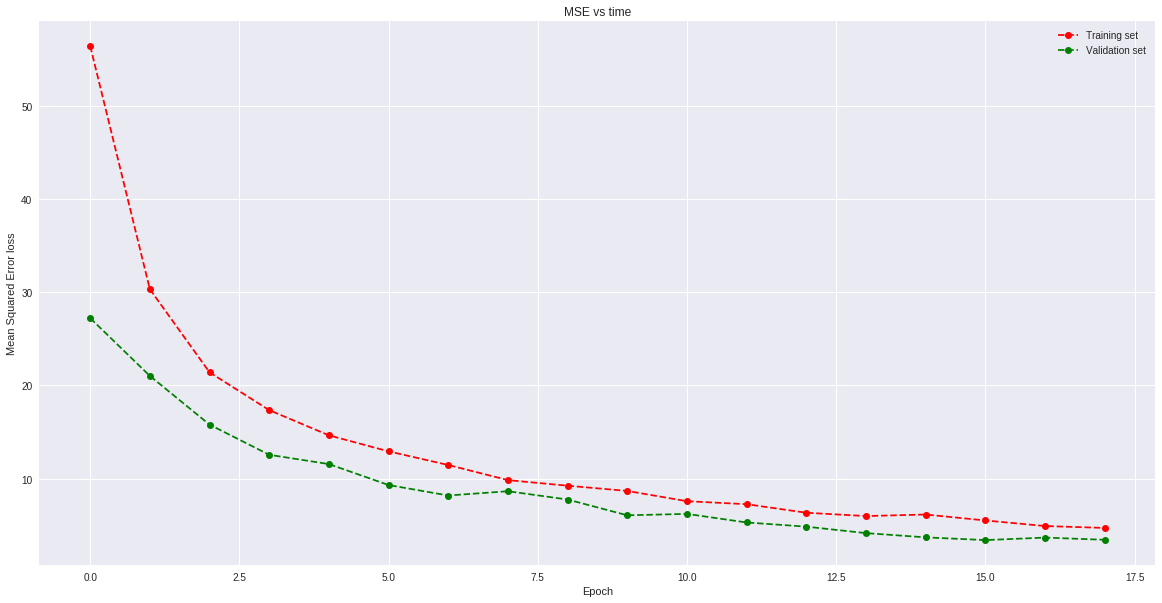

In [55]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'ro--')
plt.plot(history['val_loss'], 'go--')
plt.title('MSE vs time')
plt.ylabel('Mean Squared Error loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.savefig('./assets/MSE_per_epoch.png')
plt.show()
plt.close()

In [42]:
# def opticalFlowOverlay(image_current, image_next):
#     """
#     input: image_current, image_next (RGB images)
#     output: mask
#     """
#     feature_params = dict( maxCorners = 500,
#                        qualityLevel = 0.1,
#                        minDistance = 7,
#                        blockSize = 5 )
#     lk_params = dict( winSize  = (15, 15),
#                   maxLevel = 2,
#                   criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
#     image_current_saved = np.copy(image_current)
#     image_next_saved = np.copy(image_next)
    
#     image_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
#     image_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
#     p0 = cv2.goodFeaturesToTrack(image_current, mask = None, **feature_params)

#     p1, st, err = cv2.calcOpticalFlowPyrLK(image_current, image_next, p0, None, **lk_params)


#     color = np.random.randint(0, 255, (100, 3))

#     mask = np.zeros_like(image_current)

#     # Select good points
#     good_new = p1[st == 1]
#     good_old = p0[st == 1]
#     for i, (new, old) in enumerate(zip(good_new, good_old)):
#         a, b = new.ravel() # flatten
#         c, d = old.ravel()
#         mask = cv2.arrowedLine(mask, (a,b), (c, d), color[i].tolist(), 1, 8)
        
#         image_next = cv2.circle(image_next_saved, (a, b), 1, color[i].tolist(), -1)
#         image_next_fg = cv2.bitwise_and(image_next, image_next, mask = mask)
        
#     dst = cv2.add(image_next, image_next_fg)
#     return dst

In [44]:
# import os
# # given an input image

# data = train_data                  
# for idx in range(1, len(data.index) - 1):
#     row_now = data.iloc[[idx]].reset_index()
#     row_prev = data.iloc[[idx - 1]].reset_index()
#     row_next = data.iloc[[idx + 1]].reset_index()

#     # Find the 3 respective times to determine frame order (current -> next)

#     time_now = row_now['img_index'].values[0]
#     time_prev = row_prev['img_index'].values[0]
#     time_next = row_next['img_index'].values[0]

#     if abs(time_now - time_prev) == 1 and time_now > time_prev:
#         row1 = row_prev
#         row2 = row_now
#     elif abs(time_next - time_now) == 1 and time_next > time_now:
#         row1 = row_now
#         row2 = row_next
#     else:
#         print('Error generating row')

#     x1, y1 = preprocess_image_valid_from_path(row1['img_path'].values[0], row1['speed'].values[0])
#     x2, y2 = preprocess_image_valid_from_path(row2['img_path'].values[0], row2['speed'].values[0])
#     img_diff = x1 - x2
   
#     # reshape image difference to feed into model.predict
#     img_diff = opticalFlowDense(x1, x2)
#     img_diff_reshaped = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
        
#     # grab the mean speed y to check our model against
#     y = np.mean([y1, y2])
                                   
#     # note: y2 is the actual speed of the frame x2 which we will use for accurate prediction, even though
#     # our model is based on x1 and x2
                                   
#     # TODO: retrain model to evaluate y2 instead of mean(y1, y2) and check differences
                                   
#     prediction = model.predict(img_diff_reshaped)
#     error = abs(prediction - y2)
#     truth = y2
                                       
#     predict_path = os.path.join(PREDICT_PATH, str(idx) + '.jpg')
                                   
#     # overwrite the prediction of y2 onto image x2
#     # save overwritten image x2 to new directory ./data/predict

                                   
#     # Make a copy 
#     dst = np.copy(x2)
    
#     dst = opticalFlowOverlay(x1, x2) # This is a sparse optical flow overlay    
    
#     # to write new image via openCV
#     offset = 10
#     FONT_SIZE = 0.3
#     THICKNESS = 1
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     cv2.putText(dst,'pred: ' + str(prediction[0][0])[:5],(5,offset), font, FONT_SIZE,(0,0,0), THICKNESS,cv2.LINE_AA)
#     cv2.putText(dst,'truth: ' + str(y2)[:5],(5,offset * 2), font, FONT_SIZE,(0,20,255), THICKNESS,cv2.LINE_AA)
#     cv2.putText(dst, 'error: ' + str(error[0][0])[:5], (5, offset*3),font, FONT_SIZE, (255, 0, 0), THICKNESS, cv2.LINE_AA)
    
#     # convert back to BGR for writing
#     dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
#     cv2.imwrite(predict_path, dst)
    
# print('done!')

In [43]:
# from moviepy.editor import VideoFileClip
# from moviepy.editor import ImageSequenceClip
# import glob
# import os

# images = [os.path.join(PREDICT_PATH, str(i) + '.jpg') for i in range(1, len(data.index) - 1)]
# clip = ImageSequenceClip(images, fps=11.7552)
# clip.write_videofile("movie_vtest2.mp4", fps=11.7552)
# print('done!')